<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/RoBerta_Model_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
RoBERTa_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [42]:
def get_bert_input(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='tf')
    return inputs

def get_bert_last_hidden_state_output(inputs,model):
    output = model(inputs)
    return output.last_hidden_state.numpy()

def get_bert_pooler_output(inputs,model):
    output=model(inputs)
    return output.pooler_output.numpy()

def convert_to_bert_last_hidden_state_output(text,model):
    inputs =get_bert_input(text)
    output = get_bert_last_hidden_state_output(inputs,model)
    return output

def convert_to_bert_pooler_output(text,model):
    inputs =get_bert_input(text)
    output = get_bert_pooler_output(inputs,model)
    return  output

def model_prediction_input(text,max_squence_length,bert_model):
    inputs = tokenizer(text, padding=True, truncation=True,max_length=max_squence_length, return_tensors='tf')
    padded_input = tokenizer.pad(inputs, max_length=max_squence_length, padding='max_length', return_tensors='tf')
    output=bert_model(padded_input)
    return output.last_hidden_state.numpy()


In [43]:
import pandas as pd
import numpy as np
df_new=pd.read_csv('/content/drive/MyDrive/UBC_project/cleaned_data_no_special_characters.csv',encoding='UTF-8')

In [44]:
df_new = df_new[(df_new['claims'].str.split().str.len() > 3) & (df_new['claims'].str.split().str.len() < 20)]
df_new.shape

(3850, 2)

<Axes: xlabel='claims_labels'>

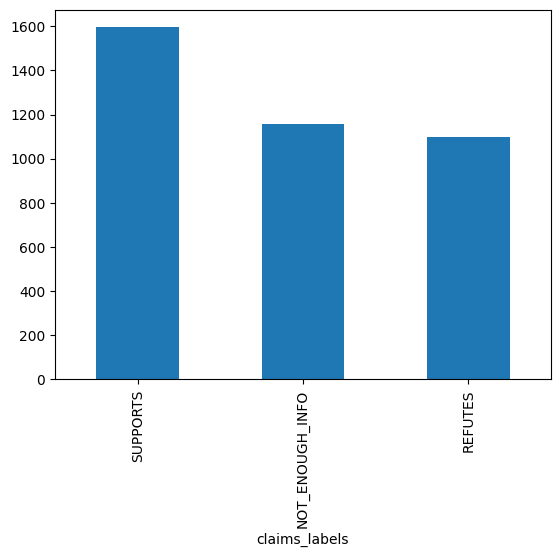

In [45]:
df_new['claims_labels'].value_counts().plot(kind='bar')

Balanced Class Distribution:
claims_labels
SUPPORTS           1099
NOT_ENOUGH_INFO    1099
REFUTES            1099
Name: count, dtype: int64


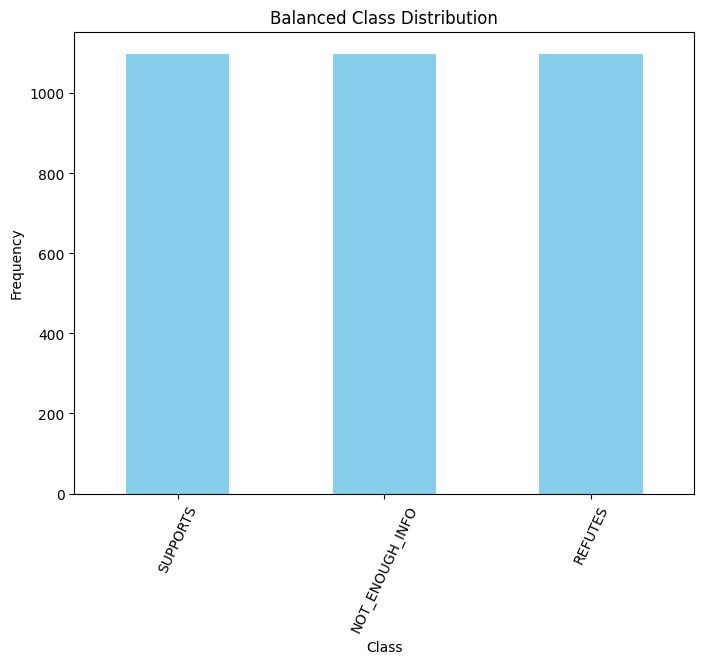

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
min_class_size = min(df_new['claims_labels'].value_counts())

balanced_train_data = pd.DataFrame(columns=['claims','claims_labels'])

class_distribution = df_new['claims_labels'].value_counts()

for genre, count in class_distribution.items():
  class_data = df_new[df_new['claims_labels'] == genre].sample(n=min_class_size, random_state=22)
  balanced_train_data = pd.concat([balanced_train_data, class_data], ignore_index=True)

balanced_train_data.describe()
balanced_class_distribution = balanced_train_data['claims_labels'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)

plt.figure(figsize=(8, 6))
balanced_class_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()


In [ ]:
df_new=balanced_train_data

In [47]:
def ohe(text):

    if text=='SUPPORTS':
         return 2
    elif text=='NOT_ENOUGH_INFO':
         return 1
    elif text=='REFUTES' :
          return 0
    return 0

df_new['claims_labels']=df_new['claims_labels'].apply(lambda x:ohe(x))

df_new=df_new.sample(n=3500,random_state=22)
df_new.shape

(3500, 2)

<Axes: xlabel='claims_labels'>

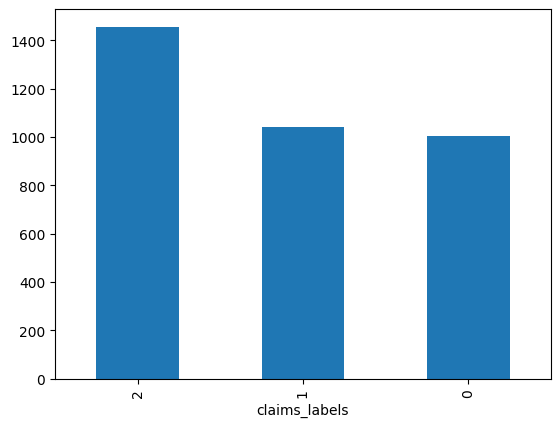

In [48]:
df_new['claims_labels'].value_counts().plot(kind='bar')

In [49]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(df_new['claims'],df_new['claims_labels'],test_size=0.001,random_state=2)

In [ ]:
x_train = []

def create_list(text):
    x_train.append(text)

X_train.apply(lambda x: create_list(x))

print(x_train)

In [51]:
x_train = convert_to_bert_last_hidden_state_output(x_train,RoBERTa_model)
print(x_train.shape)
max_squence_length = x_train.shape[1]
embedding_dim = x_train.shape[2]

(3496, 33, 768)


#Function for calculating F1_score

In [52]:
from keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    class_ids = K.arange(0, K.max(y_true) + 1, dtype='int32')
    true_positives = K.sum(K.cast(K.equal(y_true, y_pred), 'float32'), axis=0)
    false_positives = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.equal(y_pred, class_ids[:, None]), 'float32'), axis=1)
    false_negatives = K.sum(K.cast(K.not_equal(y_true, y_pred) & K.equal(y_true, class_ids[:, None]), 'float32'), axis=1)

    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    f1_score_mean = K.mean(f1)
    return f1_score_mean

In [53]:
!pip install pydot
!pip install graphviz

#Model Architecture

In [54]:
from keras.layers import Input,Flatten, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Attention
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model

# BERT output is feeded as input
input_layer = Input(shape=(max_squence_length,embedding_dim,), name='claims_input')

# Convolutional layer
conv_layer = Conv1D(filters=256, kernel_size=5, activation='relu', name='Conv1D_layer')(input_layer)
pooling_layer = MaxPooling1D(pool_size=2, name='MaxPooling_layer')(conv_layer)

# Bidirectional LSTM layer
bilstm_layer = Bidirectional(LSTM(100, return_sequences=True, name='BiLSTM_layer'))(pooling_layer)

# Attention mechanism
attention = Attention(name='Attention_layer')([bilstm_layer, bilstm_layer])
attention_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')(attention)

# Dense layers
dense_layer = Dense(100, activation='relu', name='Dense_layer_1')(attention_pooling)
dropout_layer = Dropout(0.6, name='Dropout_layer_1')(dense_layer)
dense_layer_2 = Dense(50, activation='relu', name='Dense_layer_2')(dropout_layer)
dropout_layer_2 = Dropout(0.5, name='Dropout_layer_2')(dense_layer_2)

# Output layer for multi-class classification
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout_layer_2)


#the model
model = Model(inputs=input_layer, outputs=output_layer)
loss= tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss, metrics=['accuracy'])

#model summary
model.summary()
plot_model(model, to_file='roberta_model_plot.png', show_shapes=True, show_layer_names=True)

checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/UBC_project/RoBERTa_model.h5', monitor='accuracy', save_best_only=True, mode='max', verbose=1)





Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 claims_input (InputLayer)   [(None, 33, 768)]            0         []                            
                                                                                                  
 Conv1D_layer (Conv1D)       (None, 29, 256)              983296    ['claims_input[0][0]']        
                                                                                                  
 MaxPooling_layer (MaxPooli  (None, 14, 256)              0         ['Conv1D_layer[0][0]']        
 ng1D)                                                                                            
                                                                                                  
 bidirectional_9 (Bidirecti  (None, 14, 200)              285600    ['MaxPooling_layer[0][0]

Epoch 1/30
30/31 [============================>.] - ETA: 0s - loss: 1.0901 - accuracy: 0.3907
Epoch 1: accuracy improved from -inf to 0.39174, saving model to /content/drive/MyDrive/UBC_project/RoBERTa_model.h5
31/31 [==============================] - 6s 76ms/step - loss: 1.0902 - accuracy: 0.3917 - val_loss: 1.0194 - val_accuracy: 0.4714
Epoch 2/30
 2/31 [>.............................] - ETA: 1s - loss: 1.0430 - accuracy: 0.4350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/31 [============================>.] - ETA: 0s - loss: 1.0220 - accuracy: 0.4530
Epoch 2: accuracy improved from 0.39174 to 0.45189, saving model to /content/drive/MyDrive/UBC_project/RoBERTa_model.h5
31/31 [==============================] - 2s 65ms/step - loss: 1.0236 - accuracy: 0.4519 - val_loss: 1.0176 - val_accuracy: 0.4643
Epoch 3/30
30/31 [============================>.] - ETA: 0s - loss: 1.0010 - accuracy: 0.4530
Epoch 3: accuracy improved from 0.45189 to 0.45384, saving model to /content/drive/MyDrive/UBC_project/RoBERTa_model.h5
31/31 [==============================] - 2s 62ms/step - loss: 1.0000 - accuracy: 0.4538 - val_loss: 0.9911 - val_accuracy: 0.4690
Epoch 4/30
30/31 [============================>.] - ETA: 0s - loss: 0.9772 - accuracy: 0.4777
Epoch 4: accuracy improved from 0.45384 to 0.47724, saving model to /content/drive/MyDrive/UBC_project/RoBERTa_model.h5
31/31 [==============================] - 2s 62ms/step - loss: 0.9776 - accuracy: 0.4772 - val_loss: 0.9836 - 

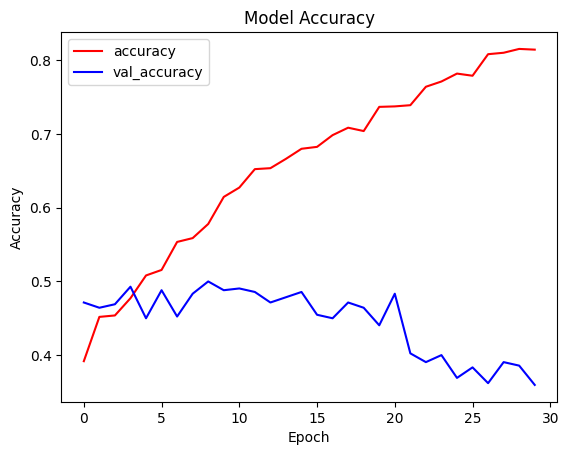

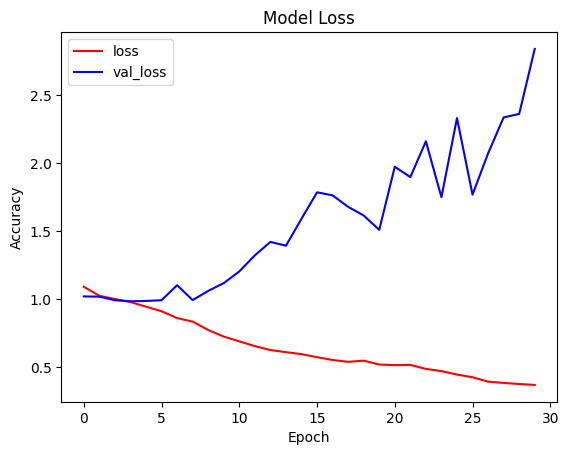

In [55]:
#training parameters
batch_size = 100
epochs = 30

history = model.fit(
    x_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.12,
    callbacks=[checkpoint_callback]
)

#graph
plt.plot(history.history['accuracy'], color='red',label='accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#graph
plt.plot(history.history['loss'], color='red',label='loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Text Cleaning Block

In [56]:
import re
import numpy as np

def remove_link(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    if pattern:
        return pattern.sub(r'', text)
    else:
        return text

import string
Exclude=string.punctuation



def remove_punctuation(text):
    return text.translate(str.maketrans('','',Exclude))

def remove_html_tag(text):
    i=0
    pattern=re.compile(r'<.*?>')
    if pattern:
      list=np.array(pattern.findall(text))
      n=list.shape[0]
    for i in range(n):
      text= text.replace(list[i],'')
    return text


import nltk

from nltk.corpus import stopwords

nltk.download('stopwords')


extra=stopwords.words('english')
stopwrd=np.array(extra)

def remove_stopwords(text, stopwords):
    split_text = text.split()
    filtered_text = []

    for word in split_text:
        if word not in stopwords:
            filtered_text.append(word)

    result = ' '.join(filtered_text)
    return result

def remove_emoji(text):
    pattern=re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    if pattern:
       list= pattern.findall(text)
    return pattern.sub(r'', text)

import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatization(text):
    doc=nlp(text)
    text_=[]
    for word in doc:
       text_.append(word.lemma_)

    result = ' '.join(text_)
    return result

def text_cleaning(text,stopwords):
    text=text.lower()
    text=remove_link(text)
    text=remove_html_tag(text)
    text=remove_emoji(text)
    #text=remove_stopwords(text,stopwords)
    text=remove_punctuation(text)
    text=lemmatization(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
text_cleaning('Climate change is a natural process and not influenced by human activities',stopwrd)

'climate change be a natural process and not influence by human activity'

In [58]:
from keras.utils import custom_object_scope
class InferenceModel:
    def __init__(self, model_path='/content/drive/MyDrive/UBC_project/RoBERTa_model.h5'):
        self.model_path = model_path
        self.model = self.load_model()

    def load_model(self):
        return tf.keras.models.load_model(self.model_path)


    def predict(self, input_data):
        input_data = text_cleaning(input_data,stopwrd)
        list=[]
        list.append(input_data)
        input_data=model_prediction_input(list,max_squence_length,RoBERTa_model)
        predictions = self.model.predict(input_data)
        return predictions



In [59]:
inference_model = InferenceModel()
def generate_output(text):
    output = inference_model.predict(text)
    return output


1/1 [==============================] - 1s 675ms/step


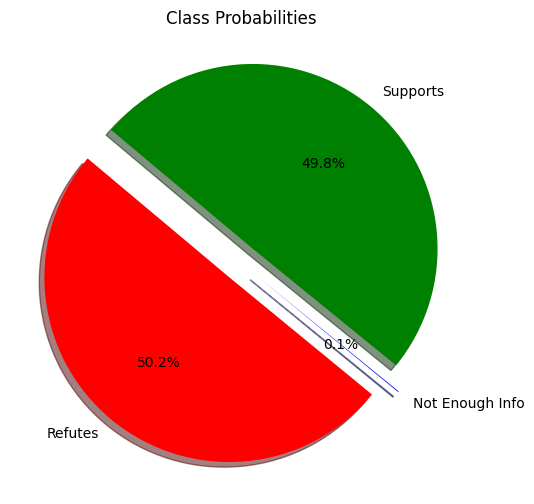

In [60]:
# Generate probabilities for the given text
probabilities = generate_output('Climate change is a natural process and not influenced by human activities')

# Extract probabilities for each class
class_0_prob = probabilities[0, 0]
class_1_prob = probabilities[0, 1]
class_2_prob = probabilities[0, 2]

# Define the class labels
classes = ['Refutes', 'Not Enough Info', 'Supports']

# Define the probabilities
values = [class_0_prob, class_1_prob, class_2_prob]

# Define colors for the pie chart
colors = ['red','blue','green']

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(values, labels=classes, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True, explode=(0.1, 0.1, 0.1))

# Adding a title
plt.title('Class Probabilities')

# Display the pie chart
plt.show()


In [ ]:
!pip install pyngrok
!pip install flask-ngrok

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token('2jLw4uo6rdnvKmujYT1Hi5aRcZD_4RPxMKhdbLbZAe8Q83xDA')
public_url = ngrok.connect(5000).public_url
print(public_url)


from flask import Flask, render_template, request, jsonify, render_template_string
from flask_ngrok import run_with_ngrok
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def index():
    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Climate Change Misinformation Checker</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background: url('https://cdn.prod.website-files.com/656a6f5ca4824808211181c5/65a7ef109c30ede6f2c52e51_240111-Climate-change-Blog-2.jpg') no-repeat center center fixed;
                background-size: cover;
                margin: 0;
                display: flex;
                flex-direction: column;
                align-items: center;
                justify-content: center;
                min-height: 100vh;
                color: white;
            }

            .container {
                background-color: rgba(0, 0, 25, 0.7);
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 0 10px rgba(0, 0, 0, 0.5);
                width: 90%;
                max-width: 800px;
                text-align: center;
                color: #333;
            }

            h1 {
                color: #fff;
            }

            p {
                color: #fff;
            }

            textarea {
                width: 100%;
                height: 40px;
                padding: 10px;
                border: 1px solid #ddd;
                border-radius: 5px;
                margin-bottom: 20px;
                font-size: 16px;
            }

            button {
                background-color: #007BFF;
                color: white;
                padding: 10px 20px;
                border: none;
                border-radius: 5px;
                cursor: pointer;
                font-size: 16px;
            }

            button:hover {
                background-color: #49FF33;
            }

            #result {
                margin-top: 20px;
                font-size: 18px;
            }

            .media {
                display: flex;
                flex-direction: column;
                align-items: center;
                margin-top: 20px;
            }

            .media img {
                max-width: 100%;
                border-radius: 10px;
                margin-bottom: 20px;
            }

            .media video {
                max-width: 100%;
                border-radius: 10px;
                margin-bottom: 20px;
            }
            .chart-container {
                width: 50%;
                height: 200px;
                margin-top: 20px;
                align-items: center;
                text-align: center;
                display: flex;
                justify-content: center;
                border-radius: 10px;
                box-shadow: 1 0 10px rgba(0, 0, 0, 0.5);
            }
        </style>
        <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    </head>
    <body>
        <div class="container">
            <h1>Climate Change Misinformation Checker</h1>
            <p>Enter the news content below to check if it contains misinformation.</p>
            <form id="newsForm">
                <textarea id="newsInput" name="newsInput" placeholder="Enter news content here..."></textarea>
                <button type="submit">Check Misinformation</button>
            </form>

            <div class="media">
                <h2 style="color : white ">RESULT</h2>
                <p id="resultText"></p>
                <div class="chart-container">
                <canvas id="pieChart" width="20" height="20"></canvas>
                </div>
                <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFxxei1iazWGrGNEJ-IttgK7krnibcK5irYA&s" alt="Climate Change">
                <iframe src="https://www.youtube.com/embed/EuwMB1Dal-4" allowfullscreen></iframe>
            </div>
        </div>
        <script>
    document.getElementById('newsForm').addEventListener('submit', function(event) {
        event.preventDefault();
        const newsInput = document.getElementById('newsInput').value;

        fetch('/result', {
            method: 'POST',
            headers: {
                'Content-Type': 'application/json',
            },
            body: JSON.stringify({ newsInput: newsInput }),
        })
        .then(response => response.json())
        .then(data => {
            const resultText = document.getElementById('resultText');
            const ctx = document.getElementById('pieChart').getContext('2d');

            if (data.error) {
                resultText.textContent = data.error;
            } else {
                resultText.textContent = data.result;

                // Destroy previous chart instance if it exists
                if (window.myPieChart) {
                    window.myPieChart.destroy();
                }

                // Create new chart instance
                window.myPieChart = new Chart(ctx, {
                    type: 'pie',
                    data: {
                        labels: ['Refutes', 'Not Enough Info', 'Supports'],
                        datasets: [{
                            label: 'Probability',
                            data: data.probabilities,
                            backgroundColor: ['red', 'blue', 'green'],
                            borderWidth: 1
                        }]
                    },
                    options: {
                        responsive: true,
                        cutout: 20,
                        plugins: {
                            legend: {
                                position: 'top',
                            },
                            tooltip: {
                                callbacks: {
                                    label: function(tooltipItem) {
                                        return tooltipItem.label + ': ' + tooltipItem.raw.toFixed(2) + '%';
                                    }
                                }
                            }
                        },
                        layout: {
                            padding: {
                                top: 10,
                                right: 10,
                                bottom: 10,
                                left: 10
                            }
                        },
                        animation: {
                            animateScale: true,
                            animateRotate: true
                        }
                    }
                });
            }
        })
        .catch((error) => {
            console.error('Error:', error);
        });
    });
</script>

    </body>
    </html>
    ''')

@app.route('/result', methods=['POST'])
def result():
    try:
        data = request.get_json()
        news_content = data['newsInput']
        probabilities = inference_model.predict(news_content)
        class_0_prob = float(probabilities[0, 0])
        class_1_prob = float(probabilities[0, 1])
        class_2_prob = float(probabilities[0, 2])

        result_text = f"Refutes: {class_0_prob*100:.2f}%,  Not Enough Info: {class_1_prob*100:.2f}%,  Supports: {class_2_prob*100:.2f}%"
        return jsonify(result=result_text, probabilities=[class_0_prob*100, class_1_prob*100, class_2_prob*100])

    except Exception as e:
        return jsonify(error=str(e))

if __name__ == '__main__':
    app.run()


https://6944-34-125-47-133.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://6944-34-125-47-133.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [17/Jul/2024 20:03:31] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Jul/2024 20:03:44] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 1s 1s/step


INFO:werkzeug:127.0.0.1 - - [17/Jul/2024 20:03:55] "POST /result HTTP/1.1" 200 -
